### GW tutorial 3: Generation of data and matched filtering

In [171]:
pip install pycbc

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [172]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.psd import from_txt
import random

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

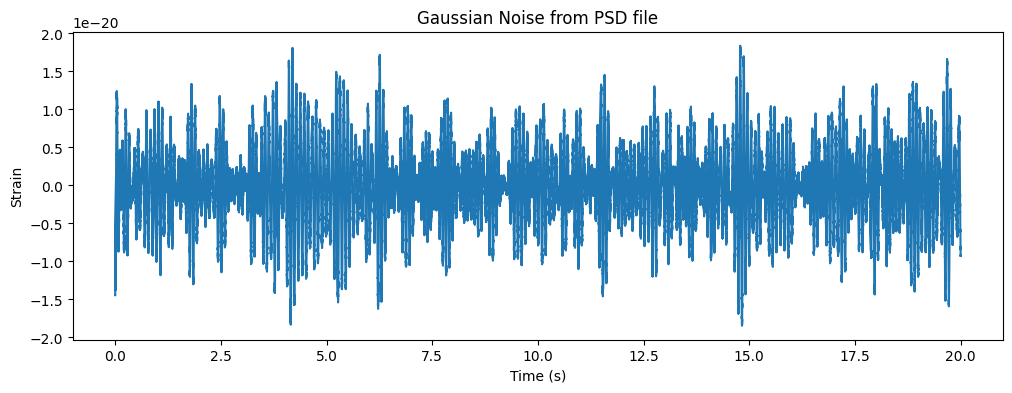

In [173]:
#variables
fs = 4096          #sampling rate
T = 20             #duration in seconds
N = fs * T         #number of samples
f_min = 10.21659   #minimum frequency, force the program to start where the PSD exists

#load PSD (make sure that the path of the file is correct)
psd = from_txt("/content/aligo_O4high.txt", length=N//2 + 1, delta_f=1.0/T, low_freq_cutoff=f_min) #makes the frequency bin match the frequency of the time series

#generate Gaussian noise with the PSD file
noise = pycbc.noise.noise_from_psd(N, 1.0/fs, psd, seed=None)

#plot the graph
times = np.arange(N) / fs

plt.figure(figsize=(12,4))
plt.plot(times, noise)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Gaussian Noise from PSD file")
plt.show()

As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

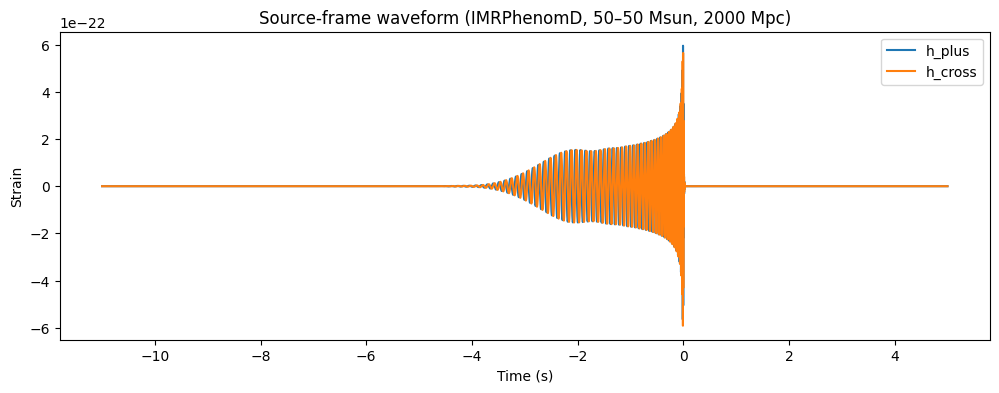

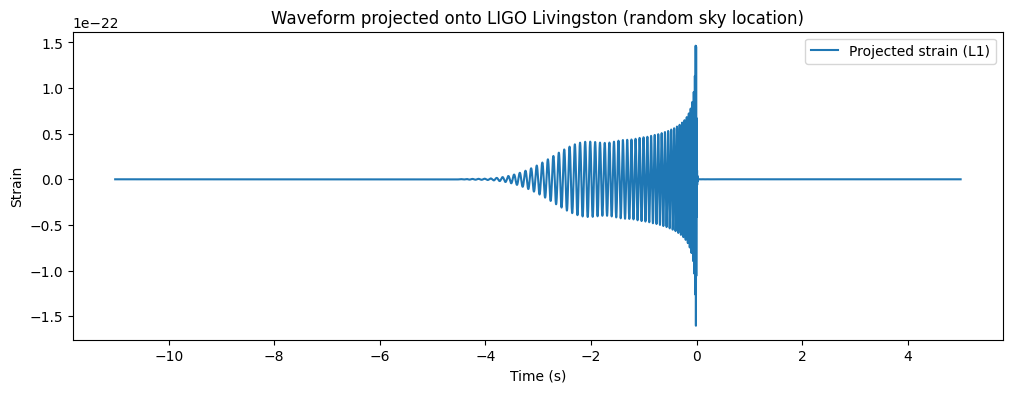

In [174]:
#waveform variables
m1 = 50
m2 = 50
distance = 2000  # Mpc --> 1 Mpc = 3.086E19 km

#generation of the gravitational wave
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1/4096,
                         f_lower=10,
                         distance=distance)

#plot the first graph
plt.figure(figsize=(12,4))
plt.plot(hp.sample_times, hp, label="h_plus")
plt.plot(hc.sample_times, hc, label="h_cross")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Source-frame waveform (IMRPhenomD, 50–50 Msun, 2000 Mpc)")
plt.legend()
plt.show()

#random sky location and polarization
ra = random.uniform(0, 2*np.pi)
dec = random.uniform(-np.pi/2, np.pi/2)
pol = random.uniform(0, 2*np.pi)

#detector object
L1 = Detector("L1")

#project waveform
hL1 = L1.project_wave(hp, hc, ra, dec, pol)

#plot the second graph
plt.figure(figsize=(12,4))
plt.plot(hL1.sample_times, hL1, label="Projected strain (L1)")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Waveform projected onto LIGO Livingston (random sky location)")
plt.legend()
plt.show()


**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?


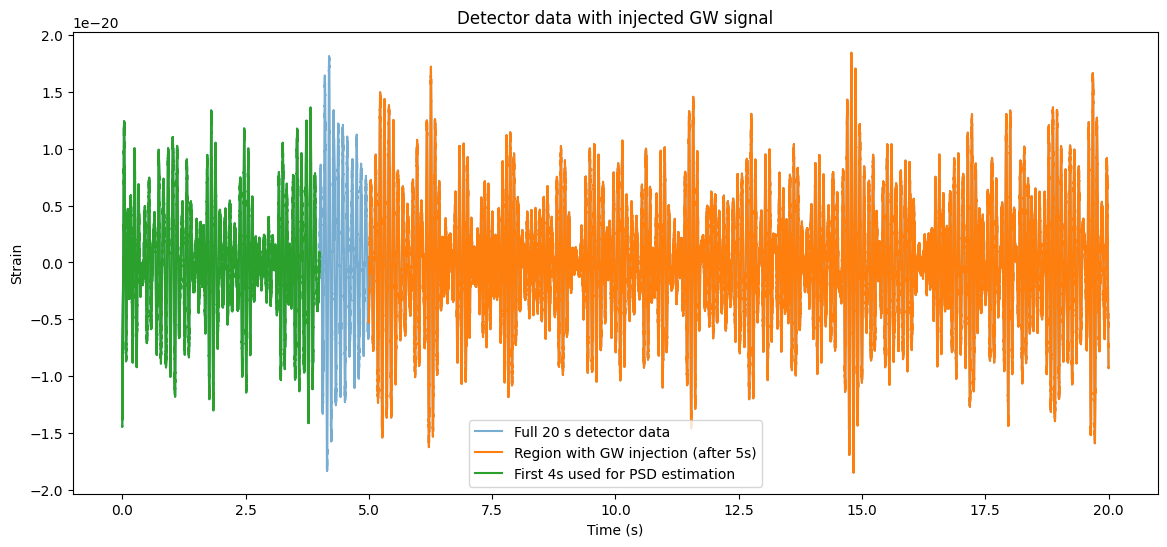

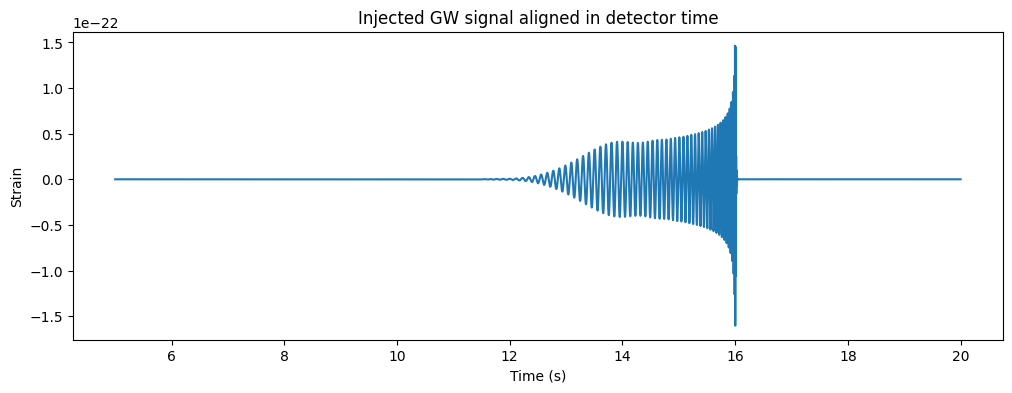

In [175]:
#variables
noise_np = np.array(noise)   #20 s of noise
h_np = np.array(hL1)         #projected GW signal

N = len(noise_np)
times = np.arange(N) / fs

#injection starts at 5 seconds
start = int(5 * fs)
available = N - start

#make sure that the waveform fits in the data segment
if len(h_np) > available:
    h_np = h_np[:available]

end = start + len(h_np)

#create detector data = noise + signal
data = noise_np.copy()
data[start:end] += h_np

#first 4s reserved for PSD estimation
psd_end = int(4 * fs)

#plot the graph
plt.figure(figsize=(14,6))
plt.plot(times, data, label="Full 20 s detector data", alpha=0.6)
plt.plot(times[start:end], data[start:end], label="Region with GW injection (after 5s)")
plt.plot(times[:psd_end], data[:psd_end], label="First 4s used for PSD estimation")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Detector data with injected GW signal")
plt.legend()
plt.show()

#plot the graph of the bonus question
gw_times = times[start:end]

plt.figure(figsize=(12,4))
plt.plot(gw_times, h_np)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Injected GW signal aligned in detector time")
plt.show()


**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


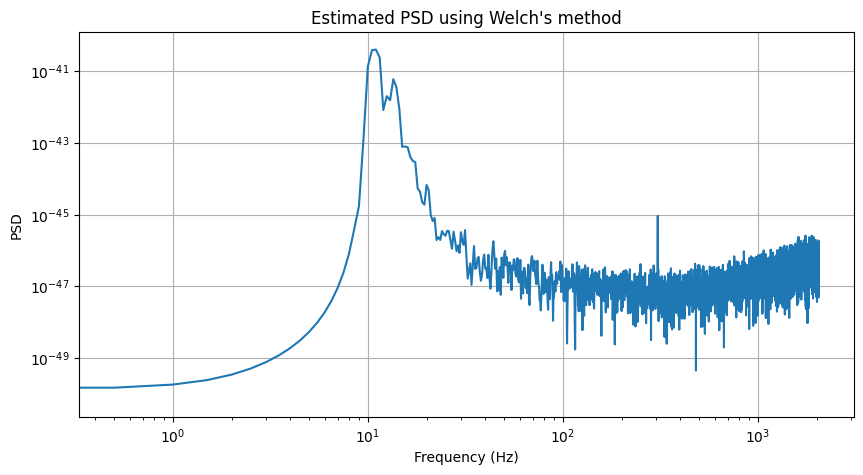

Δf of estimated PSD: 0.5
Δf of 20 s data: 0.05


In [176]:
from pycbc.types import TimeSeries
from pycbc import psd


#convert the first 4 seconds of data into a TimeSeries
psd_ts = TimeSeries(psd_data, delta_t=delta_t)

#Welch parameters (estimation of PSD)
seg_len = 2 * fs          # 2-second segments (in samples)
seg_stride = seg_len // 2 # 1-second stride

estimated_psd = psd.welch(psd_ts, seg_len=seg_len, seg_stride=seg_stride)

#plot the graph
plt.figure(figsize=(10,5))
plt.loglog(estimated_psd.sample_frequencies, estimated_psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Estimated PSD using Welch's method")
plt.grid(True)
plt.show()

#frequency resolutions
df_psd = estimated_psd.delta_f     # Δf of the PSD estimate
df_data = 1.0 / 20.0               # Δf of the 20 s data

print("Δf of estimated PSD:", df_psd)
print("Δf of 20 s data:", df_data)



Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

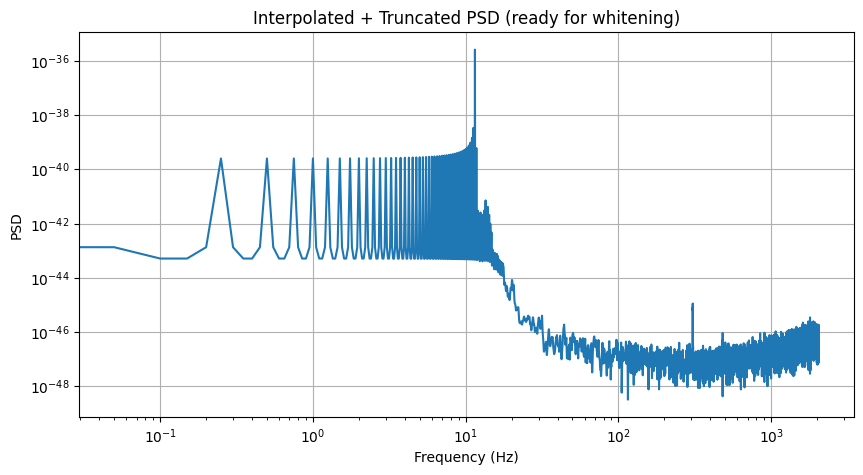

In [177]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

delta_f_data = 1.0 / 20.0   #Δf of the 20 s data
low_freq = 12.0             #reads PSD from 12 Hz
max_filter_len = 4 * fs     #4 × sampling rate

#interpolate PSD to match the data's Δf
interp_psd = interpolate(estimated_psd, delta_f_data) #this return a new PSD that has been interpolated to the desired Δf

#inverse spectrum truncation (which limits filter length)
trunc_psd = inverse_spectrum_truncation(interp_psd, max_filter_len=max_filter_len, low_frequency_cutoff=low_freq) #smoothing of the PSD

#plot the graph (PSD whitened)
plt.figure(figsize=(10,5))
plt.loglog(trunc_psd.sample_frequencies, trunc_psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Interpolated + Truncated PSD (ready for whitening)")
plt.grid(True)
plt.show()


Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

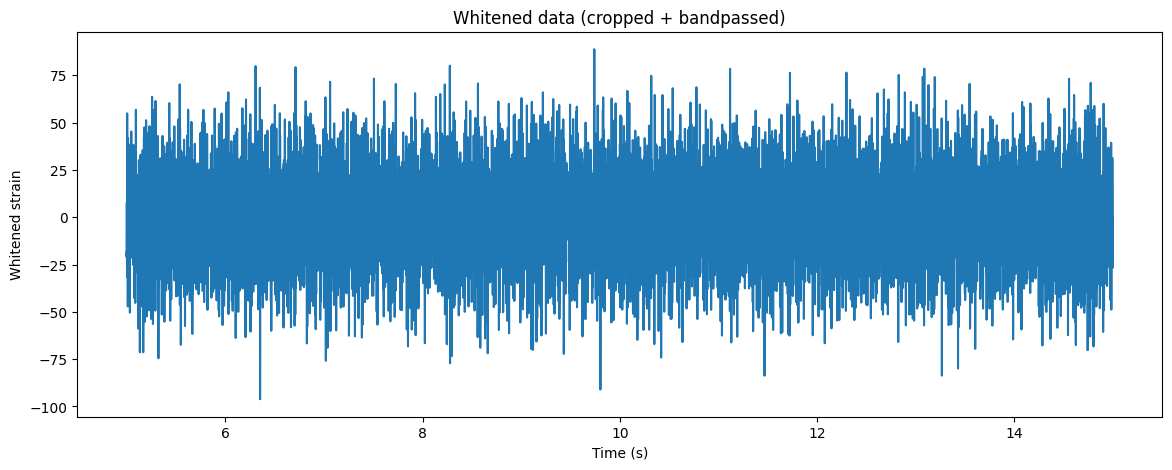

In [178]:
from pycbc.filter import highpass, lowpass


#Convert data to TimeSeries
data_ts = TimeSeries(data, delta_t=delta_t)

#FFT of the data
data_f = data_ts.to_frequencyseries()

#whitening: divide by sqrt(PSD) --> frequencies where the noise is large are supressed and if opposite they are amplified
white_f = data_f / trunc_psd**0.5

#back to time domain
white = white_f.to_timeseries()

#crop 5 seconds at start and end to remove edge corruption
white = white.crop(5, 5)

#bandpass filter (simple highpass + lowpass)
white = highpass(white, 20.0)
white = lowpass(white, 300.0)

#plot whitened data
plt.figure(figsize=(14,5))
plt.plot(white.sample_times, white)
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.title("Whitened data (cropped + bandpassed)")
plt.show()

So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

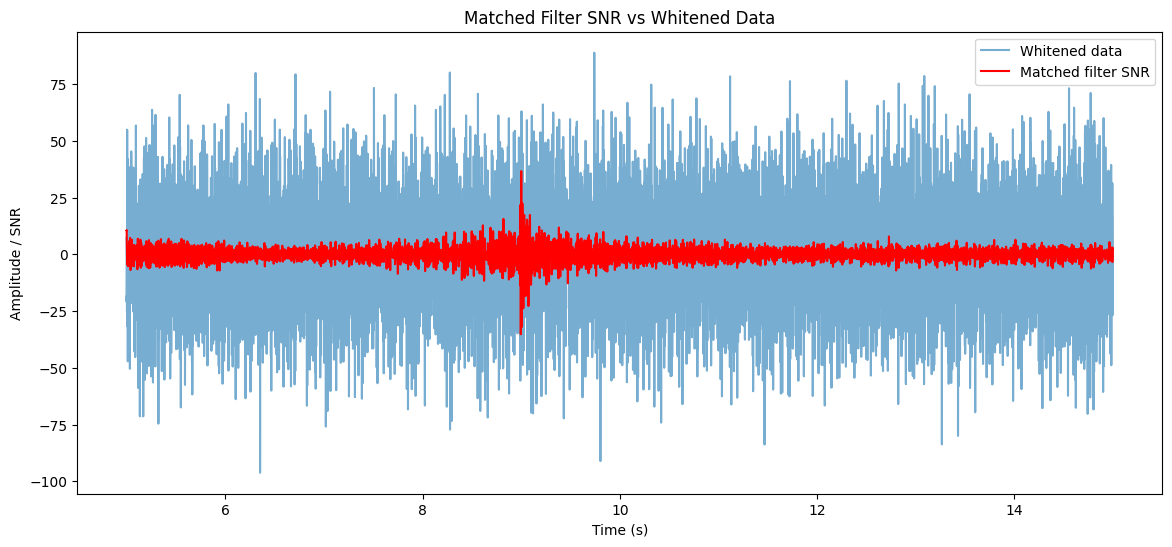

Maximum SNR = 37.946937995340754
A trigger would be generated.


In [179]:
from pycbc.filter import matched_filter, resample_to_delta_t

#prepare the template and match it with lenght of data
target_len = len(data)
template_waveform_data = hL1.data

#pad or truncate template_waveform_data to match target_len

if len(template_waveform_data) < target_len: #if data not long enough
    #pad with zeros at the end
    padded_template_data = np.zeros(target_len, dtype=template_waveform_data.dtype)
    padded_template_data[:len(template_waveform_data)] = template_waveform_data

elif len(template_waveform_data) > target_len: #if data too long -> truncate
    padded_template_data = template_waveform_data[:target_len]

else:
    padded_template_data = template_waveform_data

#create the final template TimeSeries from the prepared numpy array
template = TimeSeries(padded_template_data, delta_t=delta_t)

#compute SNR as a function of time
snr = matched_filter(template, data_ts, psd=trunc_psd, low_frequency_cutoff=12.0)

#crop on each side to avoid edge effects
snr = snr.crop(5, 5)

#plot whitened data and SNR
plt.figure(figsize=(14,6))

plt.plot(white.sample_times, white, label="Whitened data", alpha=0.6)
plt.plot(snr.sample_times, snr, label="Matched filter SNR", color="red")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude / SNR")
plt.title("Matched Filter SNR vs Whitened Data")
plt.legend()
plt.show()

#maximum SNR --> indicates the strongest match btwn template and data
max_snr = abs(snr).numpy().max()
print("Maximum SNR =", max_snr)

if max_snr > 5:  #conventional detection treshold number
    print("A trigger would be generated.")
else:
    print("No trigger would be generated.")

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.